In [81]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [82]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [83]:
row = cat.iloc[7]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-07-20HR00_evid00010'

In [84]:
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-07-20T00:00:00.487000Z
         endtime: 1970-07-21T00:00:01.996434Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572411
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [85]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

18359.513

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-07-20HR00_evid00010')

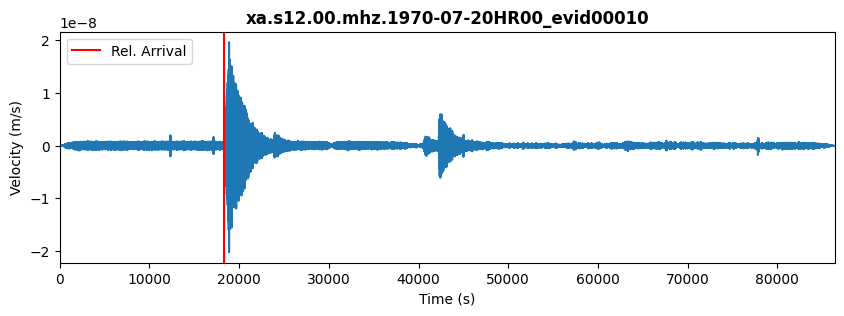

In [86]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

In [87]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

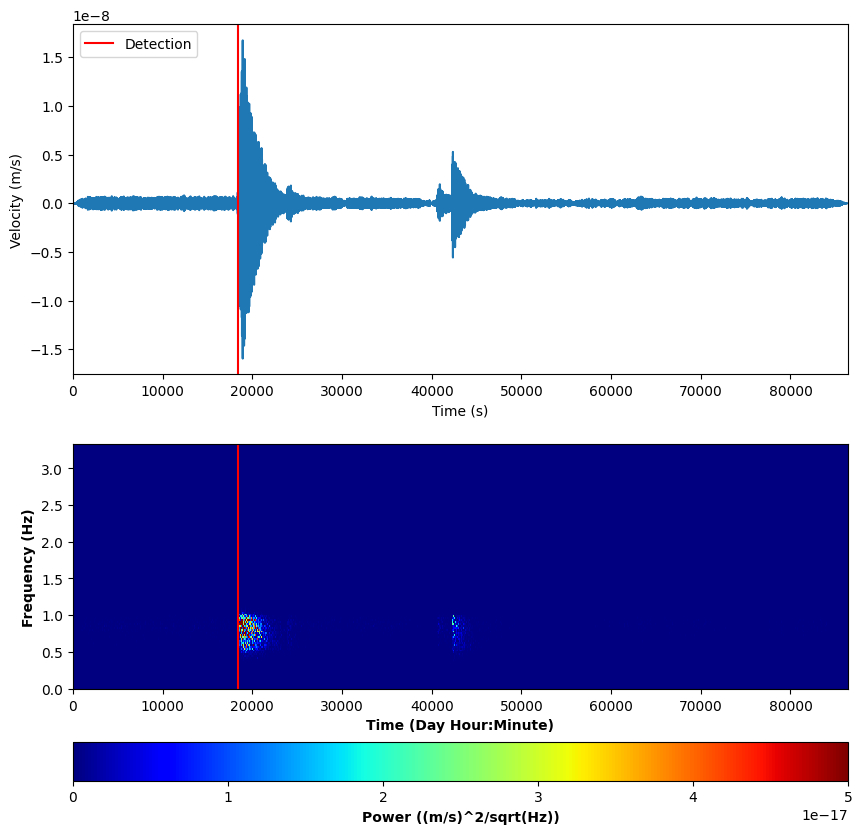

In [88]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

Text(0.5, 0, 'Time (s)')

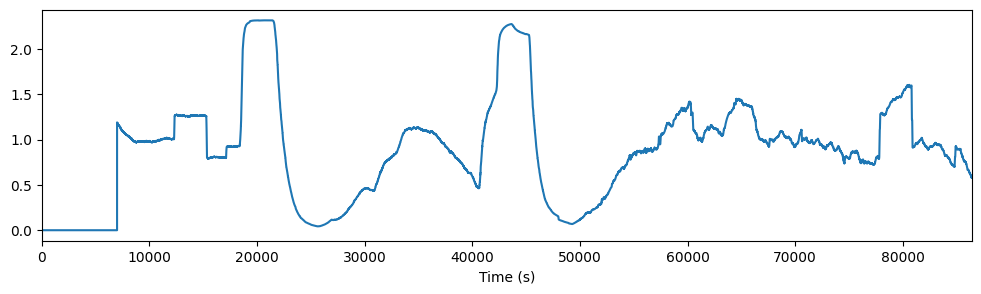

In [89]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 3000
lta_len = 7000

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')


In [90]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

# x = amplituden etc ... aus 
# y = starttimes

data = data_cat
targets = cat['time_rel(sec)']

arrival_time_rel = row
arrival_time_rel

filename                          xa.s12.00.mhz.1970-07-20HR00_evid00010
time_abs(%Y-%m-%dT%H:%M:%S.%f)                1970-07-20T05:06:00.000000
time_rel(sec)                                                    18360.0
evid                                                           evid00010
mq_type                                                        impact_mq
Name: 7, dtype: object

In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

In [11]:
# # Define a simple dataset class
# class SeismicDataset(Dataset):
#     def __init__(self, data, targets):
#         self.data = data
#         self.targets = targets

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         x = self.data[idx]
#         y = self.targets[idx]
#         return x, y
    
class Dataset:
    def __init__(self, catalog, data_directory, window_size, frame_step_size):
        self.catalog = catalog
        self.data_directory = data_directory
        self.window_size = window_size
        self.frame_step_size = frame_step_size

        self.values, self.labels, self.comment = self.load_data()
        self.start_idx_list, self.change_idxs = self.windows_start_idx()

    def load_data(self):
        
        cat = pd.read_csv(self.catalog)
        files = cat["filename"][:4]
        values = pd.DataFrame()  # Initialize as empty DataFrame
        labels = np.array([], dtype=np.float32)  # Ensure labels are of float type
        comments = np.array([])
        
        for indx, file in enumerate(files):
            path = f'{self.data_directory}{file}.csv'
            frames = pd.read_csv(path)
            frames["frame_idx"] = indx  # Add frame index to the data
            values = pd.concat([values, frames], ignore_index=True)  # Concatenate frames into values
            
            quake_time = cat["time_rel(sec)"].iloc[indx]  # Correct iloc usage
            labels_frame = np.zeros(len(frames), dtype=np.float32)  # Create labels frame of the same length as frames

            
            # Find the index where time is within quake_time +/- 1 second
            quake_idx = np.where((frames["time_rel(sec)"] > quake_time - 1) & (frames["time_rel(sec)"] < quake_time + 1))[0]
            print(quake_idx)
            if len(quake_idx) > 0:  # Check if there is any index matching the condition
                labels_frame[quake_idx[0]] = 1.0  # Mark the index with the quake event
            
            labels = np.concatenate([labels, labels_frame])  # Concatenate the labels
            comments_frame = np.full(len(frames), cat["evid"].iloc[indx])
    
            comments = np.concatenate([comments, comments_frame])

        # exclude_columns = ['take_id', 'user_id', 'comment', 'frame_idx']
        # value_columns = [col for col in frames.columns if col not in exclude_columns]

        value_columns = ["time_rel(sec)","velocity(m/s)"]
        
        
        self.backup = values
        return torch.tensor(values[value_columns].values).float(), torch.tensor(labels).float(), comments


    def windows_start_idx(self):
        change_idxs = self.backup.index[self.backup['frame_idx'] == 0].tolist()[1:]
        change_idxs.append(len(self.backup))

        result = list(range(0, (change_idxs[0]-self.window_size), self.frame_step_size))
        for change_number in range(len(change_idxs)-1):
            result.extend(list(range(change_idxs[change_number], change_idxs[change_number+1]-self.window_size, self.frame_step_size)))
        return result, change_idxs


    def __len__(self):
        return len(self.start_idx_list)

    # Real Length47499
    def __getitem__(self, idx):
        start = self.start_idx_list[idx]
        stop = self.start_idx_list[idx] + self.window_size

        batch = {"values": self.values[start:stop][:]}
        batch["labels"] = self.labels[start]
        batch["start_id"] = start
        batch["stop_id"] = stop
        batch["comment"] = self.comment[start]
        # print(batch)
        return batch



In [9]:
class SeismicEventModel(pl.LightningModule):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=1):
        super(SeismicEventModel, self).__init__()
        # Neural network layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)  # Output: Predicted event time
        return x

    def training_step(self, batch, batch_idx):
        # Get data and targets
        # print(batch)
        # x, y = batch
        x = batch["values"]
        y = batch["labels"]
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)  # Using MSE for time prediction
        return loss

    def configure_optimizers(self):
        # Adam optimizer
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# DataLoader
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
data_directory = './data/lunar/training/data/S12_GradeA/'
train_dataset = Dataset(cat_file, data_directory, 2000, 10)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = SeismicEventModel()

# Train the model
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader)

[486931 486932 486933 486934 486935 486936 486937 486938 486939 486940
 486941 486942 486943 486944]
[84264 84265 84266 84267 84268 84269 84270 84271 84272 84273 84274 84275
 84276]
[483751 483752 483753 483754 483755 483756 483757 483758 483759 483760
 483761 483762 483763 483764]
[29409 29410 29411 29412 29413 29414 29415 29416 29417 29418 29419 29420
 29421]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 192    | train
1 | relu | ReLU   | 0      | train
2 | fc2  | Linear | 4.2 K  | train
3 | fc3  | Linear | 65     | train
----------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/home/nicki/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 1/5361 [00:00<12:37,  7.07it/s, v_num=15]

/tmp/ipykernel_41872/1689717416.py:26: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_pred, y)  # Using MSE for time prediction


Epoch 1:   0%|          | 2/5361 [00:00<05:30, 16.21it/s, v_num=15]   

/tmp/ipykernel_41872/1689717416.py:26: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_pred, y)  # Using MSE for time prediction


Epoch 4:  44%|████▍     | 2351/5361 [02:27<03:09, 15.90it/s, v_num=15]

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# # Modell-Architektur
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(window_size, num_features)))
# model.add(LSTM(32))
# model.add(Dense(1))  # Zeitstempel-Vorhersage

# # Kompilierung
# # model.compile(optimizer='adam', loss='mean_squared_error')


ModuleNotFoundError: No module named 'tensorflow'